# CBB Matchup Analyzer – Hello World

This notebook is a minimal “hello world” scaffold for a college basketball (CBB) matchup analyzer.

In this step we will:
- Verify the Python environment and core libraries
- Create a tiny synthetic game log dataset for a few teams
- Compute basic tempo (possessions) and efficiency (PPP)
- Visualize a simple relationship (tempo vs offensive efficiency)

This is just a scaffold; later notebooks will:
- Load real game data
- Build matchup projections
- Compare to sportsbook lines and flag anomalies

Python version: 3.10.12
NumPy version: 2.2.6
Pandas version: 2.3.3
Matplotlib version: 3.10.8


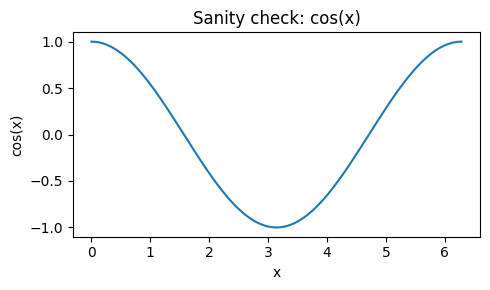

In [1]:
# Step 2: Environment check inside the notebook

import sys
import pathlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

project_root = pathlib.Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

%matplotlib inline

print("Python version:", sys.version.split()[0])
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)

# Quick smoke test plot
xs = np.linspace(0, 2 * np.pi, 200)
ys = np.cos(xs)

plt.figure(figsize=(5, 3))
plt.plot(xs, ys)
plt.title("Sanity check: cos(x)")
plt.xlabel("x")
plt.ylabel("cos(x)")
plt.tight_layout()
plt.show()

In [2]:
# Step 2: Tiny synthetic CBB game log

# We'll create a few fake games for two teams
data = [
    # date, team, opponent, pts_for, pts_against, fga, fta, orb, tov
    ("2025-12-01", "Team A", "Team B", 78, 72, 55, 20, 10, 12),
    ("2025-12-05", "Team A", "Team C", 82, 75, 58, 18, 9,  11),
    ("2025-12-08", "Team B", "Team A", 70, 80, 52, 22, 11, 14),
    ("2025-12-10", "Team B", "Team C", 65, 68, 50, 15, 8,  13),
]

columns = ["date", "team", "opponent", "pts_for", "pts_against", "fga", "fta", "orb", "tov"]

games = pd.DataFrame(data, columns=columns)
games["date"] = pd.to_datetime(games["date"])

games

,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov
0,2025-12-01,Team A,Team B,78,72,55,20,10,12
1,2025-12-05,Team A,Team C,82,75,58,18,9,11
2,2025-12-08,Team B,Team A,70,80,52,22,11,14
3,2025-12-10,Team B,Team C,65,68,50,15,8,13


In [3]:
# Step 2: Compute possessions, offensive PPP, defensive PPP

def estimate_possessions(row: pd.Series) -> float:
    """
    Classic estimate:
    Poss = FGA - ORB + TOV + 0.475 * FTA
    """
    return row["fga"] - row["orb"] + row["tov"] + 0.475 * row["fta"]

games["poss"] = games.apply(estimate_possessions, axis=1)
games["opp_poss"] = games["poss"]  # symmetric in this simple model

games["off_ppp"] = games["pts_for"] / games["poss"]
games["def_ppp"] = games["pts_against"] / games["opp_poss"]

games


,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov,poss,opp_poss,off_ppp,def_ppp
0,2025-12-01,Team A,Team B,78,72,55,20,10,12,66.500,66.500,1.172932,1.082707
1,2025-12-05,Team A,Team C,82,75,58,18,9,11,68.550,68.550,1.196207,1.094092
2,2025-12-08,Team B,Team A,70,80,52,22,11,14,65.450,65.450,1.069519,1.222307
3,2025-12-10,Team B,Team C,65,68,50,15,8,13,62.125,62.125,1.046278,1.094567


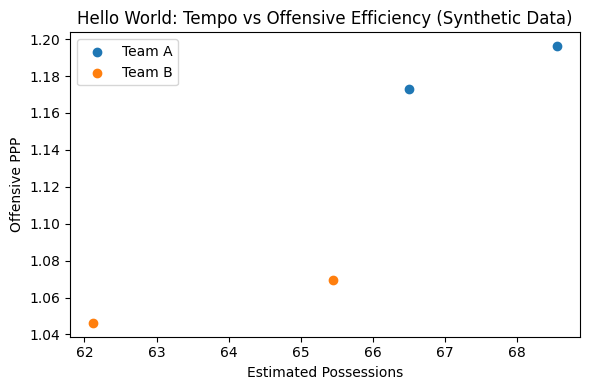

In [4]:
# Step 2: Simple visualization – tempo vs offensive efficiency

plt.figure(figsize=(6, 4))

for team in games["team"].unique():
    sub = games[games["team"] == team]
    plt.scatter(sub["poss"], sub["off_ppp"], label=team)

plt.xlabel("Estimated Possessions")
plt.ylabel("Offensive PPP")
plt.title("Hello World: Tempo vs Offensive Efficiency (Synthetic Data)")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

df = pd.read_csv("../data/cbb_games_sample.csv", parse_dates=["date"])

df


,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov,three_pa,three_pm
0,2025-01-01,Team A,Team B,78,72,55,20,10,12,25,8
1,2025-01-05,Team A,Team C,82,75,58,18,9,11,28,10
2,2025-01-08,Team B,Team A,70,80,52,22,11,14,22,6
3,2025-01-10,Team B,Team C,65,68,50,15,8,13,18,5


In [6]:
def estimate_possessions(row):
    return row.fga - row.orb + row.tov + 0.475 * row.fta

df["poss"] = df.apply(estimate_possessions, axis=1)
df["off_ppp"] = df["pts_for"] / df["poss"]
df["def_ppp"] = df["pts_against"] / df["poss"]

df


,date,team,opponent,pts_for,pts_against,fga,fta,orb,tov,three_pa,three_pm,poss,off_ppp,def_ppp
0,2025-01-01,Team A,Team B,78,72,55,20,10,12,25,8,66.500,1.172932,1.082707
1,2025-01-05,Team A,Team C,82,75,58,18,9,11,28,10,68.550,1.196207,1.094092
2,2025-01-08,Team B,Team A,70,80,52,22,11,14,22,6,65.450,1.069519,1.222307
3,2025-01-10,Team B,Team C,65,68,50,15,8,13,18,5,62.125,1.046278,1.094567


In [7]:
import numpy as np
import pandas as pd

def compute_team_profile(df, team_name):
    """
    Returns a dictionary summarizing a team's season stats.
    """
    team_df = df[df["team"] == team_name]
    if team_df.empty:
        raise ValueError(f"No games found for team {team_name}")

    profile = {
        "team": team_name,
        "games_played": len(team_df),
        "avg_possessions": team_df["poss"].mean(),
        "off_ppp": team_df["off_ppp"].mean(),
        "def_ppp": team_df["def_ppp"].mean(),
        "eff_margin": team_df["off_ppp"].mean() - team_df["def_ppp"].mean(),
        "avg_pts_for": team_df["pts_for"].mean(),
        "avg_pts_against": team_df["pts_against"].mean(),
    }

    # Optional shooting profile if available
    if "three_pa" in team_df.columns:
        profile["three_rate"] = (team_df["three_pa"] / team_df["fga"]).mean()
    if "three_pm" in team_df.columns:
        profile["three_pct"] = (team_df["three_pm"] / team_df["three_pa"].replace(0, np.nan)).mean()
    if "orb" in team_df.columns:
        misses = team_df["fga"] - team_df["three_pm"]
        profile["orb_pct"] = (team_df["orb"] / misses.replace(0, np.nan)).mean()

    return profile

# test
compute_team_profile(df, "Team A")


{'team': 'Team A',
 'games_played': 2,
 'avg_possessions': np.float64(67.525),
 'off_ppp': np.float64(1.184569739447086),
 'def_ppp': np.float64(1.088399335318603),
 'eff_margin': np.float64(0.09617040412848299),
 'avg_pts_for': np.float64(80.0),
 'avg_pts_against': np.float64(73.5),
 'three_rate': np.float64(0.46865203761755486),
 'three_pct': np.float64(0.3385714285714286),
 'orb_pct': np.float64(0.20013297872340424)}

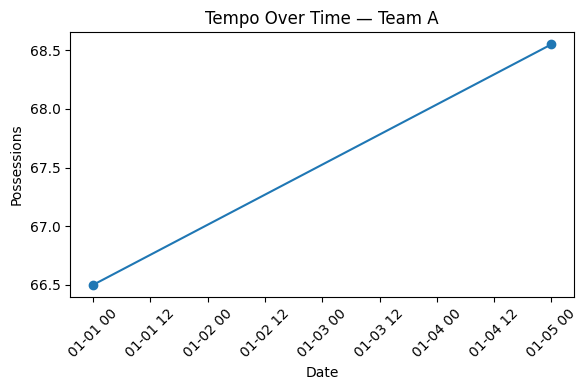

In [8]:
import matplotlib.pyplot as plt

def plot_team_tempo(df, team_name):
    team_df = df[df["team"] == team_name].sort_values("date")
    plt.figure(figsize=(6, 4))
    plt.plot(team_df["date"], team_df["poss"], marker="o")
    plt.title(f"Tempo Over Time — {team_name}")
    plt.xlabel("Date")
    plt.ylabel("Possessions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# test
plot_team_tempo(df, "Team A")


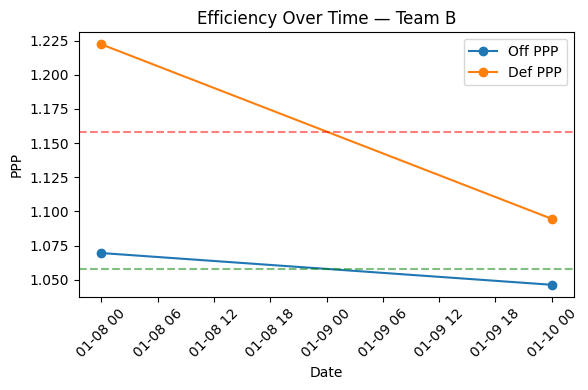

In [9]:
def plot_team_efficiency(df, team_name):
    team_df = df[df["team"] == team_name].sort_values("date")

    plt.figure(figsize=(6, 4))
    
    plt.plot(team_df["date"], team_df["off_ppp"], marker="o", label="Off PPP")
    plt.plot(team_df["date"], team_df["def_ppp"], marker="o", label="Def PPP")

    plt.axhline(team_df["off_ppp"].mean(), linestyle="--", color="green", alpha=0.5)
    plt.axhline(team_df["def_ppp"].mean(), linestyle="--", color="red", alpha=0.5)

    plt.title(f"Efficiency Over Time — {team_name}")
    plt.xlabel("Date")
    plt.ylabel("PPP")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# test
plot_team_efficiency(df, "Team B")


In [10]:
def league_summary(df):
    df = df.copy()
    
    # Add eff_margin if missing
    if "eff_margin" not in df.columns:
        df["eff_margin"] = df["off_ppp"] - df["def_ppp"]

    grouped = df.groupby("team").agg(
        avg_possessions=("poss", "mean"),
        off_ppp=("off_ppp", "mean"),
        def_ppp=("def_ppp", "mean"),
        eff_margin=("eff_margin", "mean"),
        games_played=("team", "count")
    ).reset_index()
    return grouped

league_df = league_summary(df)
league_df

,team,avg_possessions,off_ppp,def_ppp,eff_margin,games_played
0,Team A,67.5250,1.184570,1.088399,0.096170,2
1,Team B,63.7875,1.057898,1.158437,-0.100539,2


In [11]:
from dataclasses import dataclass

@dataclass
class MatchupProjection:
    teamA: str
    teamB: str
    tempo_proj: float
    teamA_ppp: float
    teamB_ppp: float
    teamA_proj_pts: float
    teamB_proj_pts: float
    total_proj_pts: float

In [12]:
from dataclasses import dataclass

@dataclass
class TeamProfile:
    team: str
    games_played: int
    tempo: float
    off_ppp: float
    def_ppp: float
    eff_margin: float
    avg_pts_for: float
    avg_pts_against: float
    three_rate: float | None = None
    three_pct: float | None = None
    orb_pct: float | None = None


def compute_team_profile_profile(df, team_name: str) -> TeamProfile:
    team_df = df[df["team"] == team_name]
    if team_df.empty:
        raise ValueError(f"No games found for team {team_name}")

    tempo = team_df["poss"].mean()
    off_ppp = team_df["off_ppp"].mean()
    def_ppp = team_df["def_ppp"].mean()
    eff_margin = off_ppp - def_ppp
    avg_pts_for = team_df["pts_for"].mean()
    avg_pts_against = team_df["pts_against"].mean()

    three_rate = None
    three_pct = None
    orb_pct = None

    if "three_pa" in team_df.columns:
        three_rate = (team_df["three_pa"] / team_df["fga"]).mean()
    if "three_pm" in team_df.columns and "three_pa" in team_df.columns:
        three_pct = (team_df["three_pm"] / team_df["three_pa"].replace(0, np.nan)).mean()
    if "orb" in team_df.columns and "three_pm" in team_df.columns:
        misses = team_df["fga"] - team_df["three_pm"]
        orb_pct = (team_df["orb"] / misses.replace(0, np.nan)).mean()

    return TeamProfile(
        team=team_name,
        games_played=len(team_df),
        tempo=tempo,
        off_ppp=off_ppp,
        def_ppp=def_ppp,
        eff_margin=eff_margin,
        avg_pts_for=avg_pts_for,
        avg_pts_against=avg_pts_against,
        three_rate=three_rate,
        three_pct=three_pct,
        orb_pct=orb_pct,
    )

# quick test
compute_team_profile_profile(df, "Team A")


TeamProfile(team='Team A', games_played=2, tempo=np.float64(67.525), off_ppp=np.float64(1.184569739447086), def_ppp=np.float64(1.088399335318603), eff_margin=np.float64(0.09617040412848299), avg_pts_for=np.float64(80.0), avg_pts_against=np.float64(73.5), three_rate=np.float64(0.46865203761755486), three_pct=np.float64(0.3385714285714286), orb_pct=np.float64(0.20013297872340424))

In [13]:
def project_matchup(teamA_name: str, teamB_name: str, df: pd.DataFrame) -> MatchupProjection:
    """
    Simple possession-based projection:
      - tempo_proj: harmonic mean of the two teams' tempos
      - team PPP: simple blend of own offense and opponent defense
      - projected points: tempo_proj * PPP
    """
    A = compute_team_profile_profile(df, teamA_name)
    B = compute_team_profile_profile(df, teamB_name)

    # 1) Projected pace (tempo)
    tempoA = A.tempo
    tempoB = B.tempo

    # guard against zeros
    if tempoA <= 0 or tempoB <= 0:
        raise ValueError("Tempo must be positive for both teams")

    tempo_proj = 2 * tempoA * tempoB / (tempoA + tempoB)  # harmonic mean

    # 2) Blend PPPs
    # own offense + opponent defense, naive average
    teamA_ppp = (A.off_ppp + B.def_ppp) / 2.0
    teamB_ppp = (B.off_ppp + A.def_ppp) / 2.0

    # 3) Project points
    teamA_pts = tempo_proj * teamA_ppp
    teamB_pts = tempo_proj * teamB_ppp
    total_pts = teamA_pts + teamB_pts

    return MatchupProjection(
        teamA=teamA_name,
        teamB=teamB_name,
        tempo_proj=tempo_proj,
        teamA_ppp=teamA_ppp,
        teamB_ppp=teamB_ppp,
        teamA_proj_pts=teamA_pts,
        teamB_proj_pts=teamB_pts,
        total_proj_pts=total_pts,
    )

# test with your synthetic teams
proj = project_matchup("Team A", "Team B", df)
proj


MatchupProjection(teamA='Team A', teamB='Team B', tempo_proj=np.float64(65.60306044740601), teamA_ppp=np.float64(1.1715034969951943), teamB_ppp=np.float64(1.0731487633026804), teamA_proj_pts=np.float64(76.85421472772326), teamB_proj_pts=np.float64(70.40184318800475), total_proj_pts=np.float64(147.256057915728))

In [14]:
def print_matchup_projection(proj: MatchupProjection, df: pd.DataFrame):
    A_profile = compute_team_profile_profile(df, proj.teamA)
    B_profile = compute_team_profile_profile(df, proj.teamB)

    print(f"Matchup: {proj.teamA} vs {proj.teamB}")
    print("-" * 40)
    print(f"Projected tempo: {proj.tempo_proj:.1f} possessions per team\n")

    print(f"{proj.teamA}:")
    print(f"  Season tempo:      {A_profile.tempo:.1f}")
    print(f"  Season off PPP:    {A_profile.off_ppp:.3f}")
    print(f"  Season def PPP:    {A_profile.def_ppp:.3f}")
    print(f"  Projected PPP:     {proj.teamA_ppp:.3f}")
    print(f"  Season avg points: {A_profile.avg_pts_for:.1f}")
    print(f"  Projected points:  {proj.teamA_proj_pts:.1f}\n")

    print(f"{proj.teamB}:")
    print(f"  Season tempo:      {B_profile.tempo:.1f}")
    print(f"  Season off PPP:    {B_profile.off_ppp:.3f}")
    print(f"  Season def PPP:    {B_profile.def_ppp:.3f}")
    print(f"  Projected PPP:     {proj.teamB_ppp:.3f}")
    print(f"  Season avg points: {B_profile.avg_pts_for:.1f}")
    print(f"  Projected points:  {proj.teamB_proj_pts:.1f}\n")

    print(f"Model total: {proj.total_proj_pts:.1f}")


# test
print_matchup_projection(proj, df)


Matchup: Team A vs Team B
----------------------------------------
Projected tempo: 65.6 possessions per team

Team A:
  Season tempo:      67.5
  Season off PPP:    1.185
  Season def PPP:    1.088
  Projected PPP:     1.172
  Season avg points: 80.0
  Projected points:  76.9

Team B:
  Season tempo:      63.8
  Season off PPP:    1.058
  Season def PPP:    1.158
  Projected PPP:     1.073
  Season avg points: 67.5
  Projected points:  70.4

Model total: 147.3


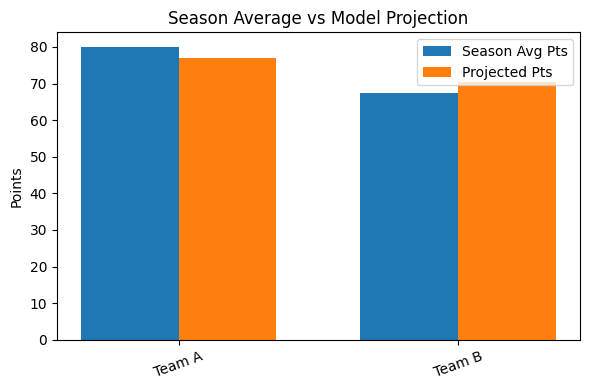

In [15]:
def plot_matchup_projection(proj: MatchupProjection, df: pd.DataFrame):
    A = compute_team_profile_profile(df, proj.teamA)
    B = compute_team_profile_profile(df, proj.teamB)

    labels = [proj.teamA, proj.teamB]
    season_avgs = [A.avg_pts_for, B.avg_pts_for]
    projections = [proj.teamA_proj_pts, proj.teamB_proj_pts]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, season_avgs, width, label="Season Avg Pts")
    plt.bar(x + width/2, projections, width, label="Projected Pts")

    plt.xticks(x, labels, rotation=20)
    plt.ylabel("Points")
    plt.title("Season Average vs Model Projection")
    plt.legend()
    plt.tight_layout()
    plt.show()

# test
plot_matchup_projection(proj, df)

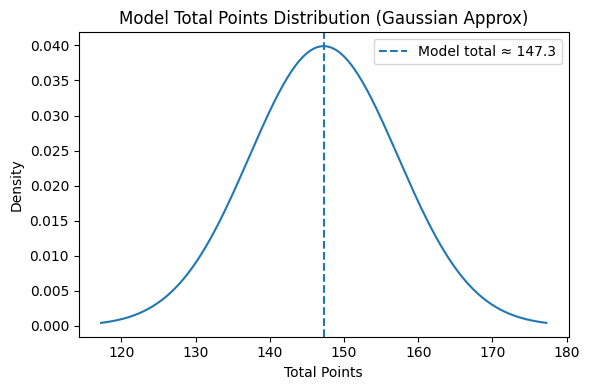

In [16]:
def plot_total_distribution(proj: MatchupProjection, std_dev: float = 10.0):
    xs = np.linspace(proj.total_proj_pts - 3*std_dev,
                     proj.total_proj_pts + 3*std_dev, 200)
    pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - proj.total_proj_pts) / std_dev) ** 2)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, pdf)
    plt.axvline(proj.total_proj_pts, linestyle="--", label=f"Model total ≈ {proj.total_proj_pts:.1f}")
    plt.title("Model Total Points Distribution (Gaussian Approx)")
    plt.xlabel("Total Points")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# test
plot_total_distribution(proj)


In [17]:
from scripts.ncaa_client import NcaaClient  # adjust import if needed based on your folder structure

client = NcaaClient()

# Try a known example from the docs: Feb 2023
schedule_json = client.get_mens_d1_schedule(year=2023, month=2)

schedule_json.keys()


dict_keys(['division', 'inputMD5Sum', 'month', 'gameDates', 'conference_name', 'created_at', 'season', 'sport'])

In [18]:
import pandas as pd

game_dates = schedule_json.get("gameDates", [])
len(game_dates), game_dates[:3]

schedule_df = pd.DataFrame(game_dates)
schedule_df.head()

,contest_date,year,weekday,games,season,day
0,02-01-2023,2023,Wed,47,2022,01
1,02-02-2023,2023,Thu,75,2022,02
2,02-03-2023,2023,Fri,15,2022,03
3,02-04-2023,2023,Sat,151,2022,04
4,02-05-2023,2023,Sun,16,2022,05


In [19]:
from scripts.ncaa_client import NcaaClient

client = NcaaClient()

scoreboard = client.get_mens_d1_scoreboard(2023, 2, 1)  # example date
scoreboard.keys()

games = scoreboard.get("games", [])
len(games), games[0]


(46,
 {'game': {'gameID': '2193264',
   'away': {'score': '50',
    'names': {'char6': 'ALBANY',
     'short': 'UAlbany',
     'seo': 'albany-ny',
     'full': 'University at Albany'},
    'winner': False,
    'seed': '',
    'description': '(6-19)',
    'rank': '',
    'conferences': [{'conferenceName': 'America East',
      'conferenceSeo': 'america-east'}]},
   'finalMessage': 'FINAL',
   'bracketRound': '',
   'title': 'UMass Lowell UAlbany',
   'contestName': '',
   'url': '/game/6052768',
   'network': '',
   'home': {'score': '66',
    'names': {'char6': 'UMASSL',
     'short': 'UMass Lowell',
     'seo': 'umass-lowell',
     'full': 'University of Massachusetts Lowell'},
    'winner': True,
    'seed': '',
    'description': '(18-6)',
    'rank': '',
    'conferences': [{'conferenceName': 'America East',
      'conferenceSeo': 'america-east'}]},
   'liveVideoEnabled': False,
   'startTime': '06:00PM ET',
   'startTimeEpoch': '1675292400',
   'bracketId': '',
   'gameState': 'fi

In [20]:
from dataclasses import dataclass
from typing import List, Optional
import datetime as dt


@dataclass
class NcaaGameMeta:
    game_id: str
    date: str           # ISO yyyy-mm-dd
    home_team: str
    away_team: str
    home_score: int
    away_score: int


def parse_scoreboard_games(scoreboard_json: dict) -> List[NcaaGameMeta]:
    out: List[NcaaGameMeta] = []
    for gwrap in scoreboard_json.get("games", []):
        game = gwrap.get("game", {})

        home = game.get("home", {})
        away = game.get("away", {})
        home_names = home.get("names", {})
        away_names = away.get("names", {})

        home_name = home_names.get("short") or home_names.get("full")
        away_name = away_names.get("short") or away_names.get("full")

        # scores are strings in the example; cast to int
        try:
            home_score = int(home.get("score", 0))
        except ValueError:
            home_score = 0
        try:
            away_score = int(away.get("score", 0))
        except ValueError:
            away_score = 0

        # extract game id from url: "/game/6154104"
        url = game.get("url", "")
        game_id = url.strip("/").split("/")[-1] if url else game.get("gameID")

        # parse startDate — handle both "MM-DD-YYYY" and "MM/DD/YYYY" formats
        start_date_str = game.get("startDate")
        if start_date_str:
            normalized = start_date_str.replace("/", "-")
            date_obj = dt.datetime.strptime(normalized, "%m-%d-%Y").date()
            date_iso = date_obj.isoformat()
        else:
            date_iso = None

        out.append(
            NcaaGameMeta(
                game_id=str(game_id),
                date=date_iso,
                home_team=home_name,
                away_team=away_name,
                home_score=home_score,
                away_score=away_score,
            )
        )
    return out

game_metas = parse_scoreboard_games(scoreboard)
len(game_metas), game_metas[:3]

(46,
 [NcaaGameMeta(game_id='6052768', date='2023-02-01', home_team='UMass Lowell', away_team='UAlbany', home_score=66, away_score=50),
  NcaaGameMeta(game_id='6052782', date='2023-02-01', home_team='Purdue', away_team='Penn St.', home_score=80, away_score=60),
  NcaaGameMeta(game_id='6052783', date='2023-02-01', home_team='Xavier', away_team='Providence', home_score=85, away_score=83)])

In [21]:
sample_game_id = game_metas[0].game_id
team_stats_json = client.get_game_team_stats(sample_game_id)
team_stats_json.keys()
team_stats_json

{'__typename': 'Boxscore',
 'title': 'MBB Boxscore',
 'contestId': 6052768,
 'description': 'UMass Lowell vs UAlbany',
 'division': 1,
 'divisionName': 'd1',
 'status': 'F',
 'period': 'FINAL',
 'minutes': None,
 'seconds': None,
 'sportCode': 'MBB',
 'teams': [{'__typename': 'ContestTeam',
   'isHome': True,
   'teamId': '2177',
   'seoname': 'umass-lowell',
   'name6Char': 'UMASSL',
   'nameFull': 'University of Massachusetts Lowell',
   'nameShort': 'UMass Lowell',
   'teamName': 'River Hawks',
   'color': '#003DA5'},
  {'__typename': 'ContestTeam',
   'isHome': False,
   'teamId': '452',
   'seoname': 'albany-ny',
   'name6Char': 'ALBANY',
   'nameFull': 'University at Albany',
   'nameShort': 'UAlbany',
   'teamName': 'Great Danes',
   'color': '#46166B'}],
 'teamBoxscore': [{'__typename': 'BoxscoreDetails',
   'teamId': 2177,
   'teamStats': {'__typename': 'TeamStatsBasketball',
    'fieldGoalsMade': '23',
    'fieldGoalsAttempted': '56',
    'fieldGoalPercentage': '0.0%',
    'f

---

# Full Pipeline: Real Games, Real Odds, Real Projections

The cells below connect the full end-to-end pipeline:
1. **Config & Setup** — imports, API keys, target date
2. **Fetch Today's Games** — NCAA scoreboard → resolve names
3. **Fetch Odds** — The Odds API (3 credits)
4. **Build Team Profiles** — season data (cached) → SOS-adjusted profiles
5. **Run Projections** — model each matchup
6. **Find Value** — compare model vs. books → top bets
7. **Visualizations** — scatter plots, bar charts

In [22]:
# === Config & Setup ===

import sys
import pathlib
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure project root is on the path
project_root = pathlib.Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

%matplotlib inline

from scripts.ncaa_client import NcaaClient
from scripts.team_name_map import build_team_identity_map, resolve_ncaa_name, get_espn_id
from scripts.odds_client import OddsClient
from scripts.stats_builder import get_or_fetch_team_season, build_team_profile, LEAGUE_AVG_PPP
from scripts.matchup_model import project_matchup as model_project_matchup
from scripts.value_finder import analyze_game_value, select_best_bets

# --- Configuration ---
# Set your Odds API key (get one free at https://the-odds-api.com)
ODDS_API_KEY = os.environ.get("ODDS_API_KEY", "YOUR_API_KEY_HERE")

# Target date for analysis (today by default)
TARGET_DATE = dt.date.today()

# ESPN uses the year the season STARTS (e.g. the 2025-26 season = 2025)
SEASON = TARGET_DATE.year if TARGET_DATE.month >= 9 else TARGET_DATE.year - 1

print(f"Target date: {TARGET_DATE}")
print(f"Season: {SEASON}")

# Initialize clients
ncaa = NcaaClient()
odds_client = OddsClient(api_key=ODDS_API_KEY)

# Build team identity map (cached for 7 days)
print("Building team identity map...")
identity_map = build_team_identity_map()
print(f"Loaded {len(identity_map)} ESPN teams")

Target date: 2026-02-13
Season: 2025
Building team identity map...
Loaded 362 ESPN teams


In [23]:
# === Fetch Today's Games ===

from scripts.ncaa_client import NcaaClient
from dataclasses import dataclass
from typing import List
import datetime as dt

@dataclass
class NcaaGameMeta:
    game_id: str
    date: str
    home_team: str
    away_team: str
    home_score: int
    away_score: int

def parse_scoreboard_games(scoreboard_json: dict) -> List[NcaaGameMeta]:
    out = []
    for gwrap in scoreboard_json.get("games", []):
        game = gwrap.get("game", {})
        home = game.get("home", {})
        away = game.get("away", {})
        home_names = home.get("names", {})
        away_names = away.get("names", {})
        home_name = home_names.get("short") or home_names.get("full")
        away_name = away_names.get("short") or away_names.get("full")
        try:
            home_score = int(home.get("score", 0))
        except (ValueError, TypeError):
            home_score = 0
        try:
            away_score = int(away.get("score", 0))
        except (ValueError, TypeError):
            away_score = 0
        url = game.get("url", "")
        game_id = url.strip("/").split("/")[-1] if url else game.get("gameID")
        start_date_str = game.get("startDate")
        if start_date_str:
            # Handle both "MM-DD-YYYY" and "MM/DD/YYYY" formats
            normalized = start_date_str.replace("/", "-")
            date_obj = dt.datetime.strptime(normalized, "%m-%d-%Y").date()
            date_iso = date_obj.isoformat()
        else:
            date_iso = None
        out.append(NcaaGameMeta(
            game_id=str(game_id),
            date=date_iso,
            home_team=home_name,
            away_team=away_name,
            home_score=home_score,
            away_score=away_score,
        ))
    return out

# Fetch scoreboard for target date
print(f"Fetching NCAA scoreboard for {TARGET_DATE}...")
scoreboard = ncaa.get_mens_d1_scoreboard(TARGET_DATE.year, TARGET_DATE.month, TARGET_DATE.day)
raw_games = parse_scoreboard_games(scoreboard)
print(f"Found {len(raw_games)} games")

# Resolve NCAA names to ESPN canonical names
games_today = []
for g in raw_games:
    home_canonical = resolve_ncaa_name(g.home_team, identity_map)
    away_canonical = resolve_ncaa_name(g.away_team, identity_map)
    if home_canonical and away_canonical:
        games_today.append({
            "game_id": g.game_id,
            "home_ncaa": g.home_team,
            "away_ncaa": g.away_team,
            "home": home_canonical,
            "away": away_canonical,
            "home_espn_id": get_espn_id(home_canonical, identity_map),
            "away_espn_id": get_espn_id(away_canonical, identity_map),
        })
    else:
        skipped = []
        if not home_canonical:
            skipped.append(f"home={g.home_team}")
        if not away_canonical:
            skipped.append(f"away={g.away_team}")
        print(f"  Skipping: {g.home_team} vs {g.away_team} (unresolved: {', '.join(skipped)})")

print(f"\nResolved {len(games_today)} / {len(raw_games)} games")
pd.DataFrame(games_today)[["home", "away"]].head(10)

Fetching NCAA scoreboard for 2026-02-13...
Found 16 games
  Skipping: Wisconsin vs Michigan St. (unresolved: away=Michigan St.)
  Skipping: Boise St. vs UNLV (unresolved: home=Boise St.)
  Skipping: N.C. A&T vs Hampton (unresolved: home=N.C. A&T)

Resolved 13 / 16 games


,home,away
0,Niagara Purple Eagles,Manhattan Jaspers
1,Harvard Crimson,Brown Bears
2,Dartmouth Big Green,Yale Bulldogs
3,Pennsylvania Quakers,Columbia Lions
4,Canisius Golden Griffins,Iona Gaels
5,Rider Broncs,Mount St. Mary's Mountaineers
6,Princeton Tigers,Cornell Big Red
7,Siena Saints,Quinnipiac Bobcats
8,Sacred Heart Pioneers,Saint Peter's Peacocks
9,George Washington Revolutionaries,George Mason Patriots


In [24]:
# === Fetch Odds ===
# Single call: 3 credits for h2h + spreads + totals

print("Fetching NCAAB odds...")
try:
    all_odds = odds_client.get_ncaab_odds(
        regions="us",
        markets="h2h,spreads,totals",
    )
    odds_client.print_usage()
    print(f"Got odds for {len(all_odds)} events")
except Exception as e:
    print(f"Odds fetch failed: {e}")
    print("Continuing without odds — set ODDS_API_KEY env var or edit the cell above")
    all_odds = []

# Build lookup: "home_canonical|away_canonical" → GameOdds
# ESPN displayName == The Odds API team names
odds_by_teams = {}
for go in all_odds:
    key = f"{go.home_team}|{go.away_team}"
    odds_by_teams[key] = go

print(f"\nOdds lookup has {len(odds_by_teams)} games")

# Show which of today's games have odds
matched_count = 0
for g in games_today:
    key = f"{g['home']}|{g['away']}"
    if key in odds_by_teams:
        matched_count += 1
print(f"Matched odds for {matched_count} / {len(games_today)} of today's games")

Fetching NCAAB odds...
Odds API — used: 27, remaining: 473
Got odds for 24 events

Odds lookup has 24 games
Matched odds for 10 / 13 of today's games


In [25]:
# === Build Team Profiles ===
# Two passes: (1) raw profiles, (2) SOS-adjusted profiles

# Collect all unique teams playing today
all_teams = {}
for g in games_today:
    all_teams[g["home"]] = g["home_espn_id"]
    all_teams[g["away"]] = g["away_espn_id"]

print(f"Need profiles for {len(all_teams)} teams\n")

# Pass 1: Fetch season data and build raw profiles (no SOS)
season_dfs = {}
raw_profiles = {}

for team_name, espn_id in all_teams.items():
    if not espn_id:
        print(f"  Skipping {team_name} — no ESPN ID")
        continue
    try:
        df_season = get_or_fetch_team_season(team_name, espn_id, SEASON)
        if df_season.empty:
            print(f"  No data for {team_name}")
            continue
        season_dfs[team_name] = df_season
        profile = build_team_profile(df_season, team_name, espn_id)
        raw_profiles[team_name] = profile
        print(f"  {team_name}: {profile.games_played} games, "
              f"Off PPP={profile.off_ppp:.3f}, Def PPP={profile.def_ppp:.3f}, "
              f"Margin={profile.eff_margin:+.3f}")
    except Exception as e:
        print(f"  Error building profile for {team_name}: {e}")

print(f"\nBuilt raw profiles for {len(raw_profiles)} teams")

# Pass 2: Rebuild with SOS (using raw_profiles as opponent_profiles)
profiles = {}
for team_name, espn_id in all_teams.items():
    if team_name not in season_dfs:
        continue
    try:
        profile = build_team_profile(
            season_dfs[team_name], team_name, espn_id,
            opponent_profiles=raw_profiles,
        )
        profiles[team_name] = profile
    except Exception as e:
        print(f"  Error rebuilding {team_name} with SOS: {e}")

print(f"Built SOS-adjusted profiles for {len(profiles)} teams")

Need profiles for 26 teams

  Fetching season data for Niagara Purple Eagles (ESPN ID: 315)...
  Niagara Purple Eagles: 31 games, Off PPP=1.036, Def PPP=1.086, Margin=-0.049
  Fetching season data for Manhattan Jaspers (ESPN ID: 2363)...
  Manhattan Jaspers: 30 games, Off PPP=1.103, Def PPP=1.078, Margin=+0.025
  Fetching season data for Harvard Crimson (ESPN ID: 108)...
  Harvard Crimson: 27 games, Off PPP=1.020, Def PPP=1.075, Margin=-0.055
  Fetching season data for Brown Bears (ESPN ID: 225)...
  Brown Bears: 27 games, Off PPP=1.059, Def PPP=1.049, Margin=+0.010
  Fetching season data for Dartmouth Big Green (ESPN ID: 159)...
  Dartmouth Big Green: 28 games, Off PPP=1.066, Def PPP=0.993, Margin=+0.073
  Fetching season data for Yale Bulldogs (ESPN ID: 43)...
  Yale Bulldogs: 29 games, Off PPP=1.182, Def PPP=1.007, Margin=+0.175
  Fetching season data for Pennsylvania Quakers (ESPN ID: 219)...
  Pennsylvania Quakers: 27 games, Off PPP=1.023, Def PPP=1.138, Margin=-0.115
  Fetching s

In [26]:
# === Run Projections ===

projections = []
projection_rows = []

for g in games_today:
    home_name = g["home"]
    away_name = g["away"]

    if home_name not in profiles or away_name not in profiles:
        continue

    home_prof = profiles[home_name]
    away_prof = profiles[away_name]

    proj = model_project_matchup(home_prof, away_prof)
    projections.append((g, proj))

    projection_rows.append({
        "Home": home_name,
        "Away": away_name,
        "Tempo": round(proj.proj_tempo, 1),
        "Home Pts": round(proj.home_pts, 1),
        "Away Pts": round(proj.away_pts, 1),
        "Total": round(proj.proj_total, 1),
        "Spread": round(proj.proj_spread, 1),
        "Home FTA": round(proj.home_fta, 1),
        "Away FTA": round(proj.away_fta, 1),
    })

proj_df = pd.DataFrame(projection_rows)
print(f"Projected {len(projections)} games\n")
proj_df

Projected 13 games



,Home,Away,Tempo,Home Pts,Away Pts,Total,Spread,Home FTA,Away FTA
0,Niagara Purple Eagles,Manhattan Jaspers,67.6,70.7,75.1,145.8,4.4,16.6,17.8
1,Harvard Crimson,Brown Bears,67.7,65.5,66.5,132.0,1.1,16.3,16.0
2,Dartmouth Big Green,Yale Bulldogs,70.7,66.7,73.4,140.1,6.7,17.7,17.2
3,Pennsylvania Quakers,Columbia Lions,69.5,70.5,75.2,145.7,4.6,16.4,17.1
4,Canisius Golden Griffins,Iona Gaels,67.7,62.6,74.1,136.7,11.4,16.4,17.6
5,Rider Broncs,Mount St. Mary's Mountaineers,67.2,66.2,68.6,134.8,2.4,16.9,16.9
6,Princeton Tigers,Cornell Big Red,70.3,73.6,78.9,152.6,5.3,17.0,17.3
7,Siena Saints,Quinnipiac Bobcats,70.4,67.9,69.1,137.0,1.2,18.9,18.4
8,Sacred Heart Pioneers,Saint Peter's Peacocks,67.9,69.5,65.7,135.2,-3.8,18.2,17.9
9,George Washington Revolutionaries,George Mason Patriots,67.4,68.0,66.4,134.4,-1.6,19.7,18.7


In [27]:
# === Find Value ===

all_opportunities = []

for g, proj in projections:
    key = f"{g['home']}|{g['away']}"
    game_odds = odds_by_teams.get(key)
    if not game_odds:
        continue

    bets = analyze_game_value(proj, game_odds)
    all_opportunities.extend(bets)

print(f"Analyzed {len(all_opportunities)} bet opportunities across {len(projections)} games\n")

# Select top bets
best_bets = select_best_bets(all_opportunities, top_n=5)

print("=" * 80)
print(f"TOP {len(best_bets)} BETS")
print("=" * 80)

current_game = None
for bet in best_bets:
    if bet.game != current_game:
        current_game = bet.game
        print(f"\n{'─' * 60}")
        print(f"  {bet.game}")
        print(f"{'─' * 60}")

    tag = f"[{bet.category.upper()}]" if bet.category else ""
    conf = f"({bet.confidence} confidence)"
    print(f"\n  {tag} {bet.bet_type.upper()} — {bet.bet_side}")
    print(f"    Book: {bet.book_line} @ {bet.book_odds:+d}")
    print(f"    Model: {bet.model_projection:.1f}")
    print(f"    Win prob: {bet.model_win_prob:.1%} vs implied {bet.implied_prob:.1%}")
    print(f"    Edge: {bet.edge_pct:+.1%} {conf}")
    print(f"    {bet.reasoning}")

Analyzed 60 bet opportunities across 13 games

TOP 10 BETS

────────────────────────────────────────────────────────────
  Harvard Crimson vs Brown Bears
────────────────────────────────────────────────────────────

  [SAFE] SPREAD — away
    Book: 8.5 @ -105
    Model: 1.1
    Win prob: 71.8% vs implied 51.2%
    Edge: +20.6% (high confidence)
    Model: Brown Bears by 1.1, book: 8.5

  [VALUE] MONEYLINE — away
    Book: 0 @ +334
    Model: 1.1
    Win prob: 52.5% vs implied 23.0%
    Edge: +29.5% (high confidence)
    Model: Brown Bears win prob 52.5%, book implied: 23.0%

────────────────────────────────────────────────────────────
  Miami (OH) RedHawks vs Ohio Bobcats
────────────────────────────────────────────────────────────

  [SAFE] TOTAL — under
    Book: 163.0 @ -110
    Model: 146.1
    Win prob: 81.2% vs implied 52.4%
    Edge: +28.8% (high confidence)
    Model total: 146.1, book: 163.0

  [VALUE] MONEYLINE — away
    Book: 0 @ +428
    Model: -0.9
    Win prob: 48.2% vs 

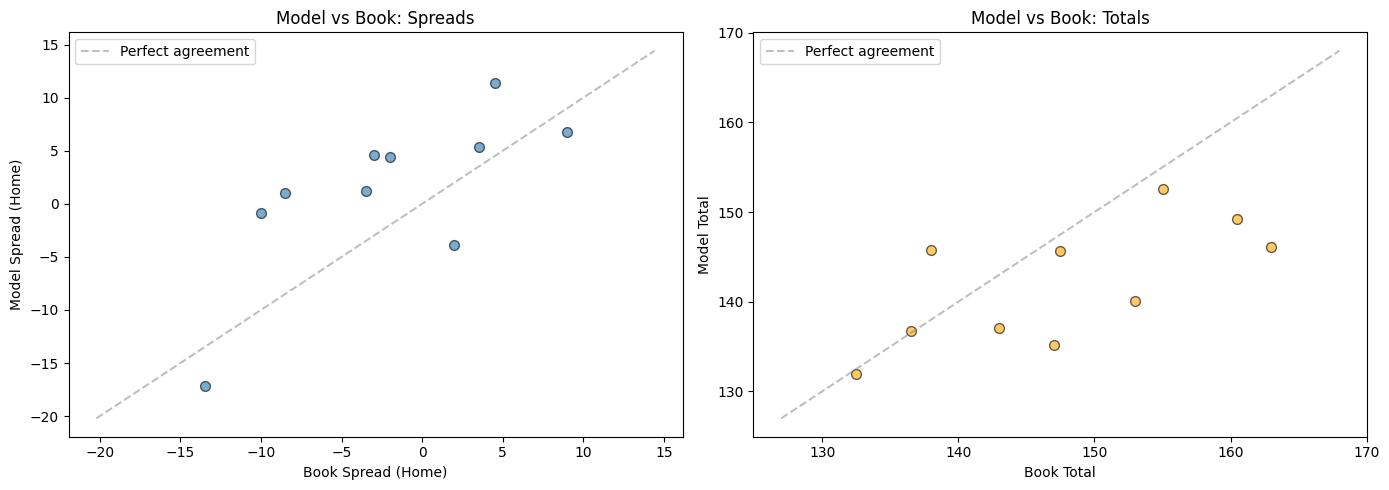

In [28]:
# === Visualizations ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 1. Model vs Book: Spreads ---
spread_data = {"model": [], "book": [], "label": []}
for g, proj in projections:
    key = f"{g['home']}|{g['away']}"
    game_odds = odds_by_teams.get(key)
    if not game_odds:
        continue
    spread_mkt = game_odds.get_consensus_line("spreads")
    if not spread_mkt:
        continue
    for oc in spread_mkt.outcomes:
        if oc.point is not None and oc.name == game_odds.home_team:
            spread_data["model"].append(proj.proj_spread)
            spread_data["book"].append(oc.point)
            # Short label: first word of home team
            spread_data["label"].append(g["home"].split()[0])
            break

ax = axes[0]
if spread_data["model"]:
    ax.scatter(spread_data["book"], spread_data["model"], alpha=0.6, edgecolors="k", s=50)
    # Perfect agreement line
    lims = [
        min(min(spread_data["book"]), min(spread_data["model"])) - 3,
        max(max(spread_data["book"]), max(spread_data["model"])) + 3,
    ]
    ax.plot(lims, lims, "--", color="gray", alpha=0.5, label="Perfect agreement")
    ax.set_xlabel("Book Spread (Home)")
    ax.set_ylabel("Model Spread (Home)")
    ax.set_title("Model vs Book: Spreads")
    ax.legend()
else:
    ax.text(0.5, 0.5, "No spread data", ha="center", va="center", transform=ax.transAxes)

# --- 2. Model vs Book: Totals ---
total_data = {"model": [], "book": []}
for g, proj in projections:
    key = f"{g['home']}|{g['away']}"
    game_odds = odds_by_teams.get(key)
    if not game_odds:
        continue
    total_mkt = game_odds.get_consensus_line("totals")
    if not total_mkt:
        continue
    for oc in total_mkt.outcomes:
        if oc.point is not None and oc.name == "Over":
            total_data["model"].append(proj.proj_total)
            total_data["book"].append(oc.point)
            break

ax = axes[1]
if total_data["model"]:
    ax.scatter(total_data["book"], total_data["model"], alpha=0.6, edgecolors="k", s=50, color="orange")
    lims = [
        min(min(total_data["book"]), min(total_data["model"])) - 5,
        max(max(total_data["book"]), max(total_data["model"])) + 5,
    ]
    ax.plot(lims, lims, "--", color="gray", alpha=0.5, label="Perfect agreement")
    ax.set_xlabel("Book Total")
    ax.set_ylabel("Model Total")
    ax.set_title("Model vs Book: Totals")
    ax.legend()
else:
    ax.text(0.5, 0.5, "No totals data", ha="center", va="center", transform=ax.transAxes)

plt.tight_layout()
plt.show()

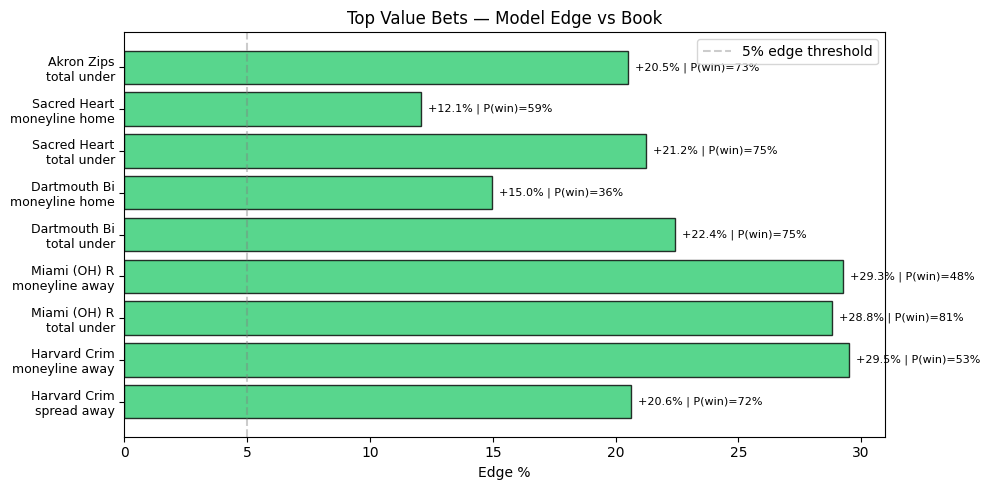

In [29]:
# === Top Value Bets Bar Chart ===

value_bets = [b for b in best_bets if b.edge_pct > 0]

if value_bets:
    labels = [f"{b.game.split(' vs ')[0][:12]}\n{b.bet_type} {b.bet_side}" for b in value_bets]
    edges = [b.edge_pct * 100 for b in value_bets]
    colors = ["#2ecc71" if b.confidence == "high" else "#f39c12" if b.confidence == "medium" else "#e74c3c"
              for b in value_bets]

    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(range(len(value_bets)), edges, color=colors, edgecolor="k", alpha=0.8)
    ax.set_yticks(range(len(value_bets)))
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel("Edge %")
    ax.set_title("Top Value Bets — Model Edge vs Book")
    ax.axvline(5, linestyle="--", color="gray", alpha=0.4, label="5% edge threshold")
    ax.legend()

    # Annotate bars
    for i, (bar, bet) in enumerate(zip(bars, value_bets)):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
                f"{bet.edge_pct:+.1%} | P(win)={bet.model_win_prob:.0%}",
                va="center", fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("No positive-edge bets found (odds may not be available)")